In [77]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.naive_bayes import MultinomialNB

# Predicting Box Office Revenue

In [78]:
#read in data
path_train = './Data/train.csv'
df = pd.read_csv(path_train)

In [79]:
df.shape

(3000, 23)

In [80]:
#create a column for the length of the the overview
df['overview_words'] = df['overview'].str.split()
df['overview_word_count'] = df['overview_words'].str.len()

#create a column for the length of the the tagline
df['tagline_words'] = df['tagline'].str.split()
df['tagline_word_count'] = df['tagline_words'].str.len()

df['overview_word_count'].fillna(0, inplace=True)
df['tagline_word_count'].fillna(0, inplace=True)

df.drop(columns = ['tagline', 'overview', 'overview_words', 'tagline_words'], inplace = True)

In [81]:
#drop poster_path because we aren't going to do image recognition
df.drop(columns = ['poster_path', 'homepage', 'Keywords'], inplace = True)

## Data Cleaning 1: Imputing for Nulls

In [82]:
df.isna().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
imdb_id                     0
original_language           0
original_title              0
popularity                  0
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
title                       0
cast                       13
crew                       16
revenue                     0
overview_word_count         0
tagline_word_count          0
dtype: int64

### Fill in Missing Genres

In [83]:
#we reviewed the df of empty genres to see if we could impute. five of the seven are russian
df['genres'].fillna(' ', inplace = True)

#Extract genre names from json

df['genres'].iloc[0]

from ast import literal_eval

df['genres_eval'] = df['genres'].map(lambda x: literal_eval(x) if x != ' ' else x)

df['genres_eval'].iloc[200]

[{'id': 35, 'name': 'Comedy'},
 {'id': 10751, 'name': 'Family'},
 {'id': 14, 'name': 'Fantasy'}]

There are many movies with multiple genres listed. There's no explanation in the data dictionary for this. We're going to assume that the first listed genre is the main genre

In [84]:
#create genre name column with the first listed genre
df['genre_name'] = df['genres_eval'].map(lambda x: x[0]['name'] if x != ' ' else ' ')

In [85]:
df['genre_name'].value_counts()

Drama              785
Comedy             604
Action             520
Adventure          187
Horror             170
Crime              147
Thriller           116
Animation           76
Documentary         71
Fantasy             68
Romance             67
Science Fiction     41
Family              36
Mystery             33
Music               20
War                 20
History             16
Western             13
                     7
Foreign              2
TV Movie             1
Name: genre_name, dtype: int64

In [86]:
#drop genre columns other than genre_name
df.drop(columns = ['genres', 'genres_eval'], inplace = True)

#create dummy columns for genre
df = pd.get_dummies(df, columns = ['genre_name'])

### Fill empty runtimes with median runtime

<AxesSubplot:>

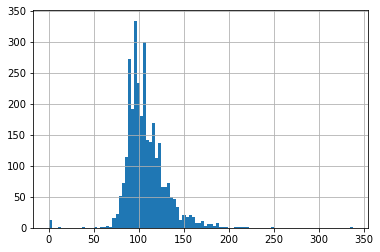

In [87]:
df['runtime'].hist(bins = 100)

Since the distribution of runtimes is approximately normal we will use median to fill the 2 empty runtime values

In [88]:
df['runtime'].fillna(np.mean(df['runtime']), inplace = True)

## Data Cleaning 2: Clean up Data Types

In [89]:
df.dtypes

id                              int64
belongs_to_collection          object
budget                          int64
imdb_id                        object
original_language              object
original_title                 object
popularity                    float64
production_companies           object
production_countries           object
release_date                   object
runtime                       float64
spoken_languages               object
status                         object
title                          object
cast                           object
crew                           object
revenue                         int64
overview_word_count           float64
tagline_word_count            float64
genre_name_                     uint8
genre_name_Action               uint8
genre_name_Adventure            uint8
genre_name_Animation            uint8
genre_name_Comedy               uint8
genre_name_Crime                uint8
genre_name_Documentary          uint8
genre_name_D

we want to simplify belongs_to_collection to either a yes or a no.

In [90]:
df['belongs_to_collection'].fillna(0, inplace = True)

df['in_collection'] = df['belongs_to_collection'].map(lambda x: 1 if x != 0 else x)

df['in_collection'].value_counts()


0    2396
1     604
Name: in_collection, dtype: int64

In [91]:
df.drop(columns = 'belongs_to_collection', inplace = True)

In [92]:
df['is_en'] = df['original_language'].map(lambda x: 1 if x == 'en' else 0)

df['is_en'].value_counts()

1    2575
0     425
Name: is_en, dtype: int64

In [93]:
df['production_countries'].fillna(' ', inplace = True)

df['countries_eval'] = df['production_countries'].map(lambda x: literal_eval(x) if x != ' ' else x)

df['countries_eval'].iloc[200]

[{'iso_3166_1': 'DE', 'name': 'Germany'},
 {'iso_3166_1': 'US', 'name': 'United States of America'}]

In [94]:
df['country_abb'] = df['countries_eval'].map(lambda x: x[0]['iso_3166_1'] if x != ' ' else ' ')

df['country_abb'].value_counts()

df = pd.get_dummies(df, columns = ['country_abb'])

In [95]:
df['production_companies'].fillna(' ', inplace = True)

df['company_eval'] = df['production_companies'].map(lambda x: literal_eval(x) if x != ' ' else x)

df['company_eval'].iloc[200]

[{'name': 'Paramount Pictures', 'id': 4},
 {'name': 'Kerner Entertainment Company', 'id': 7311}]

In [96]:
df['company_name'] = df['company_eval'].map(lambda x: x[0]['name'] if x != ' ' else ' ')

df['company_name'].value_counts()

#pd.get_dummies(df, columns = ['country_abb']);

Universal Pictures                        167
Paramount Pictures                        158
                                          156
Twentieth Century Fox Film Corporation    122
Columbia Pictures                          90
                                         ... 
Solaris Film                                1
Next Wednesday Productions                  1
Caramel Film                                1
Anarchos Productions                        1
Atípica Films                               1
Name: company_name, Length: 1065, dtype: int64

In [97]:
big_companies_list = ['Universal Pictures', 'Paramount Pictures', 'Twentieth Century Fox Film Corporation', 'Columbia Pictures']
df['big_company'] = df['company_name'].map(lambda x: 1 if x in big_companies_list else 0)

df['big_company'].value_counts()

0    2463
1     537
Name: big_company, dtype: int64

In [98]:
df['release_date'] = pd.to_datetime(df['release_date'])

In [99]:
df.drop(columns = ['spoken_languages', 'crew'], inplace = True)

In [100]:
df['status'] = df['status'].map({'Released': 1, 'Rumored': 0})

In [101]:
df['status'].value_counts()

1    2996
0       4
Name: status, dtype: int64

In [102]:
df['cast'].fillna(' ', inplace = True)

df['cast_eval'] = df['cast'].map(lambda x: literal_eval(x) if x != ' ' else x)

df['cast_eval'].iloc[200];

In [103]:
df.drop(columns=['cast', 'cast_eval'], inplace=True)

In [104]:
df.drop(columns=['company_eval', 'company_name', 'countries_eval'], inplace=True)

In [105]:
features = ['budget', 'popularity', 'runtime', 'status', 
            'overview_word_count', 'tagline_word_count',
            'in_collection', 'is_en', 'country_abb_ ', 'country_abb_AE',
       'country_abb_AR', 'country_abb_AT', 'country_abb_AU', 'country_abb_BA',
       'country_abb_BE', 'country_abb_BF', 'country_abb_BG', 'country_abb_BR',
       'country_abb_BS', 'country_abb_CA', 'country_abb_CH', 'country_abb_CL',
       'country_abb_CN', 'country_abb_CZ', 'country_abb_DE', 'country_abb_DK',
       'country_abb_ES', 'country_abb_ET', 'country_abb_FI', 'country_abb_FR',
       'country_abb_GB', 'country_abb_GR', 'country_abb_HK', 'country_abb_HU',
       'country_abb_ID', 'country_abb_IE', 'country_abb_IL', 'country_abb_IN',
       'country_abb_IR', 'country_abb_IS', 'country_abb_IT', 'country_abb_JP',
       'country_abb_KH', 'country_abb_KR', 'country_abb_LU', 'country_abb_MN',
       'country_abb_MR', 'country_abb_MT', 'country_abb_MX', 'country_abb_NA',
       'country_abb_NL', 'country_abb_NO', 'country_abb_NZ', 'country_abb_PH',
       'country_abb_PK', 'country_abb_PL', 'country_abb_QA', 'country_abb_RO',
       'country_abb_RS', 'country_abb_RU', 'country_abb_SA', 'country_abb_SE',
       'country_abb_SG', 'country_abb_TR', 'country_abb_TW', 'country_abb_UA',
       'country_abb_US', 'country_abb_UY', 'country_abb_ZA', 'big_company', 'genre_name_ ', 'genre_name_Action',
       'genre_name_Adventure', 'genre_name_Animation', 'genre_name_Comedy',
       'genre_name_Crime', 'genre_name_Documentary', 'genre_name_Drama',
       'genre_name_Family', 'genre_name_Fantasy', 'genre_name_Foreign',
       'genre_name_History', 'genre_name_Horror', 'genre_name_Music',
       'genre_name_Mystery', 'genre_name_Romance',
       'genre_name_Science Fiction', 'genre_name_TV Movie',
       'genre_name_Thriller', 'genre_name_War', 'genre_name_Western']

In [106]:
X = df[features]
y = df['revenue']

In [107]:
print(X.shape)
y.shape

(3000, 91)


(3000,)

In [108]:
X = df[features].copy()
y = df['revenue']
change_columns = X.select_dtypes(include=np.uint8).columns
X.loc[:, change_columns] = X[change_columns].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [109]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [110]:
print(lr.score(X_train, y_train))
lr.score(X_test, y_test)

0.666467734169202


0.6130598736375568

In [111]:
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV

In [112]:
ss = StandardScaler() 
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)
las = Lasso(alpha=5)

In [113]:
las.fit(X_train_sc, y_train)

C:\Users\theja\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.150430882134528e+17, tolerance: 4246370290701351.5
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=5)

In [114]:
las.score(X_train_sc, y_train)

0.6664677341690869

In [115]:
las.score(X_test_sc, y_test)

0.6130590425084426

In [116]:
ridge = Ridge(alpha=5)
ridge.fit(X_train_sc, y_train)
print(ridge.score(X_train_sc, y_train))
ridge.score(X_test_sc, y_test)

0.6664644925335654


0.6134573956088372

In [117]:
# Create dictionary of hyperparameters.
knn_params = {
    'n_neighbors': range(1, 51, 10),
    'metric': ['euclidean', 'manhattan']
}
# Instantiate our GridSearchCV object.
knn_gridsearch = GridSearchCV(KNeighborsRegressor(),
                              knn_params, 
                              cv=5, 
                              verbose=1,
                              n_jobs=8)
# Fit the GridSearchCV object to the data
knn_gridsearch.fit(X_train_sc, y_train);

print('testing score:', knn_gridsearch.score(X_train_sc, y_train))

print('training score:',knn_gridsearch.score(X_test_sc, y_test))

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    6.7s finished


testing score: 0.5669292013011751
training score: 0.4967035332032427


In [118]:
# Create dictionary of hyperparameters.
# The keys MUST match the names of the arguments!
en_params = {
    'alpha': np.logspace(-2, 2, 15),
    'l1_ratio': np.linspace(0, 1, 11)
}
# Instantiate our GridSearchCV object.
en_gridsearch = GridSearchCV(ElasticNet(), # What is the model we want to fit?
                              en_params, # What is the dictionary of hyperparameters?
                              cv=5, # What number of folds in CV will we use?
                              verbose=1,
                              n_jobs=8)
# Fit the GridSearchCV object to the data
en_gridsearch.fit(X_train_sc, y_train);

print('testing score:', en_gridsearch.score(X_train_sc, y_train))

print('training score:',en_gridsearch.score(X_test_sc, y_test))

Fitting 5 folds for each of 165 candidates, totalling 825 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   14.6s
[Parallel(n_jobs=8)]: Done 484 tasks      | elapsed:   23.1s
[Parallel(n_jobs=8)]: Done 810 out of 825 | elapsed:   29.5s remaining:    0.4s


testing score: 0.6655305805884997
training score: 0.6187120721635098


[Parallel(n_jobs=8)]: Done 825 out of 825 | elapsed:   30.4s finished


In [119]:
def score_model(pipe_name, model_abb):
    '''prints the training and testing accuracy scores'''
    print(model_abb, 'Training Score:', pipe_name.score(X_train_sc, y_train))
    print(model_abb, 'Testing Score:', pipe_name.score(X_test_sc, y_test))

In [131]:
rf_def = RandomForestRegressor(max_depth=5)
rf_def.fit(X_train_sc, y_train)
score_model(rf_def, 'rf_def')

rf_def Training Score: 0.8145366524949168
rf_def Testing Score: 0.695057381960913


In [124]:
rf_params = {
    'n_estimators': [75, 100, 150],
    'max_depth': [5, 7, 9],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [1, 5, 10]
}
rf_gs = GridSearchCV(RandomForestRegressor(), param_grid = rf_params, cv = 5, verbose=True, n_jobs=8)
rf_gs.fit(X_train_sc, y_train)


Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   21.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 405 out of 405 | elapsed:  1.9min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=8,
             param_grid={'max_depth': [5, 7, 9], 'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [75, 100, 150]},
             verbose=True)

In [125]:
print(rf_gs.best_score_)
print(rf_gs.best_params_)

0.6677795983961796
{'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 150}


# Generate Submission

To generate a kaggle submission in the future we would need to add the same columns to the testing csv that we added to the training csv. That would mean repeating a lot of the code above.